In [80]:
import cell2cell as c2c
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import obonet
%matplotlib inline

# Load Data

**Lists of Ligand-Receptor Pairs**

In [2]:
all_lr = pd.read_excel('../Data/PPI-Networks/Celegans-Curated-LR-pairs.xlsx')

In [3]:
ga_lr = pd.read_csv('../Data/PPI-Networks/Celegans-GA-Selected-LR-pairs.csv')

In [4]:
all_lr.shape

(245, 9)

**Gene-Onthology associations in C. elegans**

In [5]:
phenotype = obonet.read_obo('../Data/Onthology/phenotype_ontology.WS276.obo')

In [6]:
po_annot = c2c.io.load_go_annotations('../Data/Onthology/phenotype_association.WS276.wb.gz')

Opening GO annotations from ../Data/Onthology/phenotype_association.WS276.wb.gz
../Data/Onthology/phenotype_association.WS276.wb.gz was correctly loaded


**Gene expression**

In [109]:
excluded_cells = ['Distal_tip_cells',
                  'Sex_myoblasts',
                  'Socket_cells',
                  'Vulval_precursors',
                  'flp-1(+)_interneurons']

In [8]:
rnaseq_data = c2c.io.load_rnaseq(rnaseq_file='../Data/RNA-Seq/Celegans_RNASeqData_Cell.xlsx',
                                 gene_column='symbol',
                                 drop_nangenes=True,
                                 log_transformation=False,
                                 format='auto')

Opening RNAseq datasets from ../Data/RNA-Seq/Celegans_RNASeqData_Cell.xlsx
../Data/RNA-Seq/Celegans_RNASeqData_Cell.xlsx was correctly loaded


In [111]:
rnaseq_data = rnaseq_data.drop(excluded_cells, axis=1)

**3D-atlas**

In [9]:
atlas = pd.read_csv('../Data/Digital-3D-Map/Celegans_L1_3D_Atlas_CellTypes.csv')
atlas = atlas.loc[~atlas['Cell Type'].isnull()].reset_index(drop=True)

**Metadata**

In [121]:
meta = c2c.io.load_metadata(metadata_file='../Data/RNA-Seq/Celegans_cell_metadata.tsv',
                            rnaseq_data=rnaseq_data,
                            sample_col='#SampleID',
                            format='auto')

../Data/RNA-Seq/Celegans_cell_metadata.tsv was correctly loaded


# Analysis

In [10]:
all_genes = list(set(all_lr[['Ligand_WB', 'Receptor_WB']].values.flatten()))

In [11]:
ga_genes = list(set(ga_lr[['Ligand_WB', 'Receptor_WB']].values.flatten()))

In [12]:
all_annot = po_annot.loc[po_annot.Gene.isin(all_genes)]

In [13]:
ga_annot = po_annot.loc[po_annot.Gene.isin(ga_genes)]

In [14]:
all_annot['Onthology'] = all_annot['GO'].apply(lambda x: phenotype.nodes[x]['name'])

/Users/earmingol/opt/anaconda3/envs/c2c_dev/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [15]:
ga_annot['Onthology'] = ga_annot['GO'].apply(lambda x: phenotype.nodes[x]['name'])

/Users/earmingol/opt/anaconda3/envs/c2c_dev/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [16]:
tests = ['morphology phenotype', 'cell migration']

In [154]:
genes = []
both_genes = []
for key_word in tests:
    all_test = all_annot.loc[all_annot.Onthology.str.contains(key_word)].Name.unique()
    ga_test = ga_annot.loc[ga_annot.Onthology.str.contains(key_word)].Name.unique()
    
    print('PHENOTYPE: {}'.format(key_word))
    print('Expected ratio in background: {}'.format(len(all_test) / len(all_genes)))
    print('Observed ratio in GA-selection: {}'.format(len(ga_test) / len(ga_genes)))
    print(ga_test)
    genes.append(ga_test.tolist())
    
    test = c2c.stats.enrichment.fisher_representation(len(ga_genes), len(ga_test), len(all_genes), len(all_test))
    print('Depletion - Odds: {}; P-value: {}'.format(test['odds'][0], test['pval'][0]))
    print('Enrichment - Odds: {}; P-value: {}'.format(test['odds'][1], test['pval'][1]))
    print('')
    
    both_genes.append(all_test.tolist())

PHENOTYPE: morphology phenotype
Expected ratio in background: 0.04736842105263158
Observed ratio in GA-selection: 0.1016949152542373
['daf-2' 'lin-17' 'lin-18' 'lin-44' 'mom-2' 'epi-1']
Depletion - Odds: 4.830188679245283; P-value: 0.9956272998197243
Enrichment - Odds: 4.830188679245283; P-value: 0.026860302232248286

PHENOTYPE: cell migration
Expected ratio in background: 0.21578947368421053
Observed ratio in GA-selection: 0.3559322033898305
['cam-1' 'cfz-2' 'cwn-1' 'dbl-1' 'epi-1' 'lag-2' 'let-2' 'lin-12' 'lin-17'
 'lin-44' 'mab-20' 'mig-1' 'mom-2' 'pat-3' 'unc-5' 'unc-6' 'unc-129'
 'ddr-1' 'ina-1' 'nid-1' 'rig-6']
Depletion - Odds: 3.067105263157895; P-value: 0.9994379045167932
Enrichment - Odds: 3.067105263157895; P-value: 0.0019113679915507085



# Visualization

In [155]:
expression = rnaseq_data.gt(10)

In [156]:
# Colors from figure S14 in C elegans paper (cell type expression data)
colors = {'Coelomocytes': (0.6509803921568628, 0.33725490196078434, 0.1568627450980392), # Brown
          'Neurons': (0.596078431372549, 0.3058823529411765, 0.6392156862745098), # Purple
          'Hypodermal/rectal cells': (0.30196078431372547, 0.6862745098039216, 0.2901960784313726), # Green
          'Pharyngeal cells': (0.21568627450980393, 0.49411764705882355, 0.7215686274509804), # Blue
          'Intestine': (1.0, 1.0, 0.2), # Yellow
          'Body/muscular cells': (0.8941176470588236, 0.10196078431372549, 0.10980392156862745), # Red
          'Excretory/Socket/Sheath cells': (1.0, 0.4980392156862745, 0.0), # Orange
          'Sexual cells': (0.9686274509803922, 0.5058823529411764, 0.7490196078431373)} # Pink

In [157]:
cell_colors = meta[['#SampleID', 'Groups']].set_index('#SampleID')
cell_colors['Groups'] = cell_colors['Groups'].map(colors)

**Only genes associated with phenotypes and that were GA-selected**

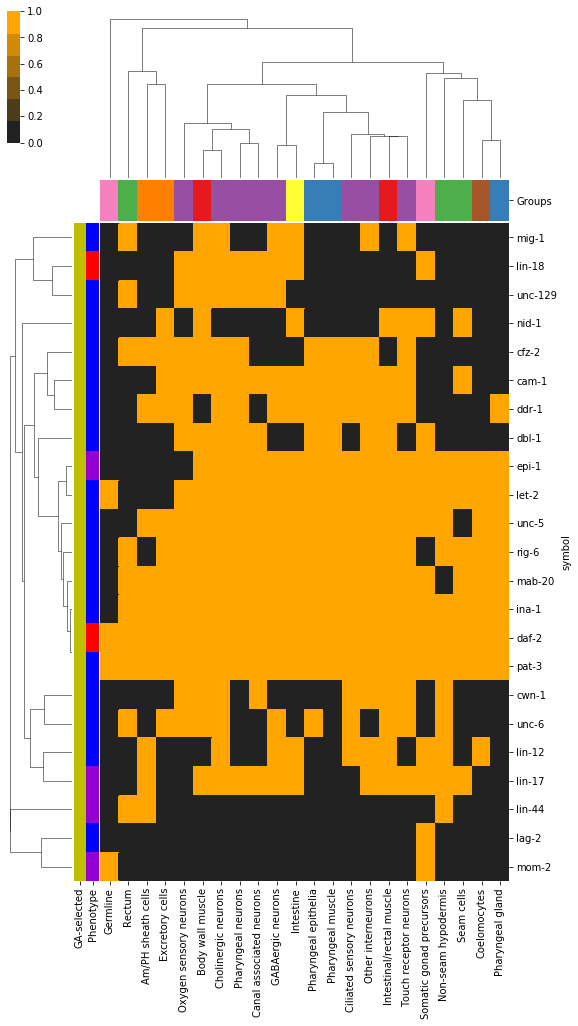

In [167]:
#gene_list = all_lr[['Ligand_symbol', 'Receptor_symbol']].values.flatten().tolist()
gene_list = genes[0] + genes[1]
gene_list = sorted(set(gene_list))

colors = dict()
for g in gene_list:
    if (g in both_genes[0]) and (g in both_genes[1]):
        colors[g] = 'darkviolet'
    elif (g in both_genes[0]):
        colors[g] = 'red'
    elif (g in both_genes[1]):
        colors[g] = 'blue'
    else:
        colors[g] = 'gray'
        
colors2 = dict()
for g in gene_list:
    if (g in genes[0]) or (g in genes[1]):
        colors2[g] = 'y'
    else:
        colors2[g] = 'whitesmoke'

color_df = pd.DataFrame(columns=['Phenotype'])
for k, v in colors.items():
    color_df.at[k, 'Phenotype'] = v
    
for k, v in colors2.items():
    color_df.at[k, 'GA-selected'] = v

cm = sns.clustermap(expression.loc[gene_list],
                    cmap=sns.dark_palette('orange'),
                    col_cluster=True,
                    row_cluster=True,
                    row_colors=color_df[['GA-selected', 'Phenotype']],
                    col_colors=cell_colors,
                    figsize=(9, 16),
                    metric='jaccard',
                    method='complete',
                   )

_ = cm.ax_heatmap.set_xticklabels(cm.data2d.columns.str.replace('_', ' '))

**All genes in complete list of LR pairs that are associated with phenotypes**

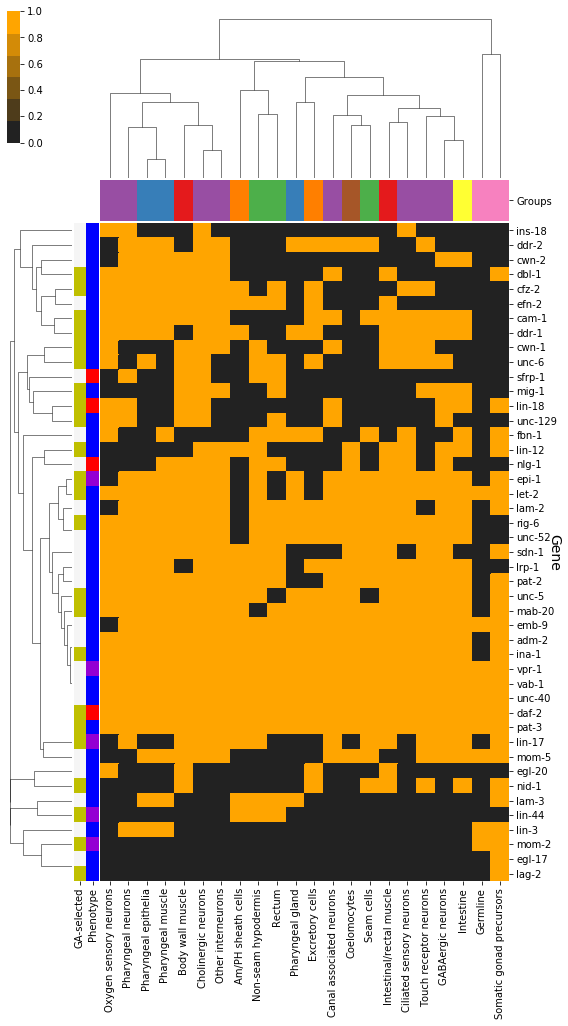

In [181]:
gene_list = both_genes[0] + both_genes[1]
gene_list = sorted(set(gene_list))

colors = dict()
for g in gene_list:
    if (g in both_genes[0]) and (g in both_genes[1]):
        colors[g] = 'darkviolet'
    elif (g in both_genes[0]):
        colors[g] = 'red'
    elif (g in both_genes[1]):
        colors[g] = 'blue'
    else:
        colors[g] = 'gray'
        
colors2 = dict()
for g in gene_list:
    if (g in genes[0]) or (g in genes[1]):
        colors2[g] = 'y'
    else:
        colors2[g] = 'whitesmoke'

color_df = pd.DataFrame(columns=['Phenotype'])
for k, v in colors.items():
    color_df.at[k, 'Phenotype'] = v
    
for k, v in colors2.items():
    color_df.at[k, 'GA-selected'] = v

cm = sns.clustermap(expression.loc[gene_list],
                    cmap=sns.dark_palette('orange'),
                    col_cluster=True,
                    row_cluster=True,
                    row_colors=color_df[['GA-selected', 'Phenotype']],
                    col_colors=cell_colors,
                    figsize=(9, 16),
                    metric='jaccard',
                    method='complete',
                   )

_ = cm.ax_heatmap.set_xticklabels(cm.data2d.columns.str.replace('_', ' '))
cm.ax_heatmap.set_ylabel('Gene', fontsize=14, rotation=-90)

plt.savefig('../Figures/Phenotype-Association.svg',
                dpi=300,
                bbox_inches='tight')

**All genes in complete list of LR pairs**

Text(153.2059171597633, 0.5, 'Gene')

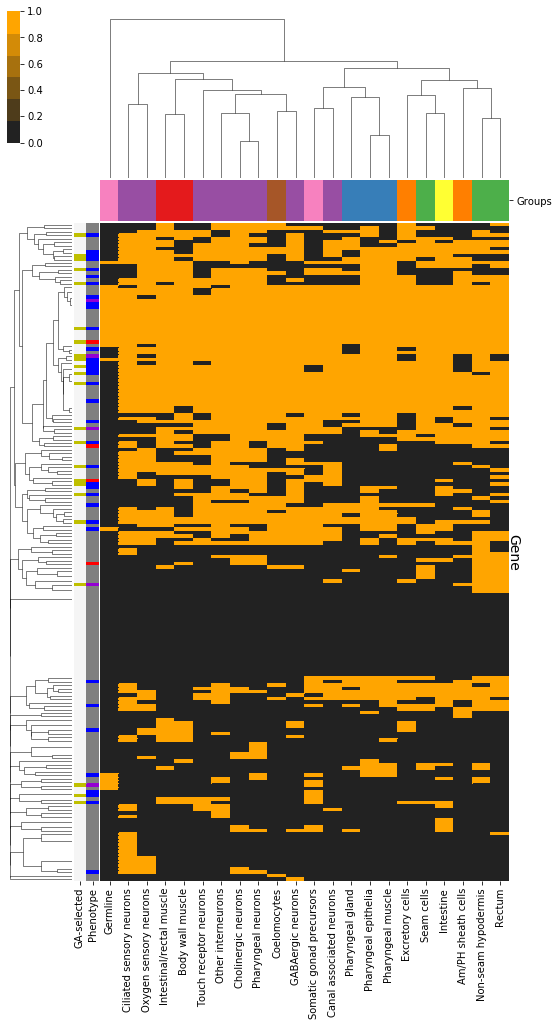

In [179]:
gene_list = all_lr[['Ligand_symbol', 'Receptor_symbol']].values.flatten().tolist()
gene_list = sorted(set(gene_list))

colors = dict()
for g in gene_list:
    if (g in both_genes[0]) and (g in both_genes[1]):
        colors[g] = 'darkviolet'
    elif (g in both_genes[0]):
        colors[g] = 'red'
    elif (g in both_genes[1]):
        colors[g] = 'blue'
    else:
        colors[g] = 'gray'
        
colors2 = dict()
for g in gene_list:
    if (g in genes[0]) or (g in genes[1]):
        colors2[g] = 'y'
    else:
        colors2[g] = 'whitesmoke'

color_df = pd.DataFrame(columns=['Phenotype'])
for k, v in colors.items():
    color_df.at[k, 'Phenotype'] = v
    
for k, v in colors2.items():
    color_df.at[k, 'GA-selected'] = v

cm = sns.clustermap(expression.loc[gene_list],
                    cmap=sns.dark_palette('orange'),
                    col_cluster=True,
                    row_cluster=True,
                    row_colors=color_df[['GA-selected', 'Phenotype']],
                    col_colors=cell_colors,
                    figsize=(9, 16),
                    metric='jaccard',
                    method='complete',
                   )

_ = cm.ax_heatmap.set_xticklabels(cm.data2d.columns.str.replace('_', ' '))
_ = cm.ax_heatmap.set_yticklabels([])

cm.ax_heatmap.tick_params(axis='y', which='both', right=False)
cm.ax_heatmap.set_ylabel('Gene', fontsize=14, rotation=-90)

In [182]:
len(set(both_genes[0] + both_genes[1]))

45

In [183]:
len(set(genes[0] + genes[1]))

23

In [185]:
len(set(both_genes[0]))

9

In [186]:
len(set(genes[0]))

6

In [187]:
len(set(both_genes[1]))

41

In [188]:
len(set(genes[1]))

21